In [1]:
from normalizer import *

import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
sp98 = pd.read_csv('data/sp98.csv')
sp95 = pd.read_csv('data/sp95.csv')

sp98.head()

,distance,consume,speed,temp_outside,AC,rain,snow,sun
0,5.4,3.3,32,7,0,0,0,0
1,2.0,9.9,21,4,0,0,0,0
2,14.2,5.1,32,7,0,0,0,0
3,16.0,4.9,25,8,0,0,0,0
4,11.8,4.9,25,11,0,0,0,0


## Random Forest Regression

Como descubrimos tras pobar varios tipos de dataset (con distintas variables) para varios tipos de modelos de regresión, el que mejor se adaptaba a las predicciones del consumo para ambos tipos de gasolina era el RandomForestRegression.

Dicho modelo puede ser mejorado regulando los distintos prámetros de los que consta. Para esta tarea, primero implementaré un RandomizedSearchCV, funcionalidad de la librería sklearn que, dado un gran rango de valores para cada parámetro, nos ayudará a estrechar el cérco de la mejor combinación posible, probando aleatoriamente y con Cross Validation, el número de combinaciones que estén programadas.

Como cada tipo de gasolina ofrece datos distintos, realizaré cada modelo por separado.

### Gasolina SP98

El primer paso será dividir los datos en train y test, aprovechando también para normalizar y escalar todas las variables independientes.

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (228). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


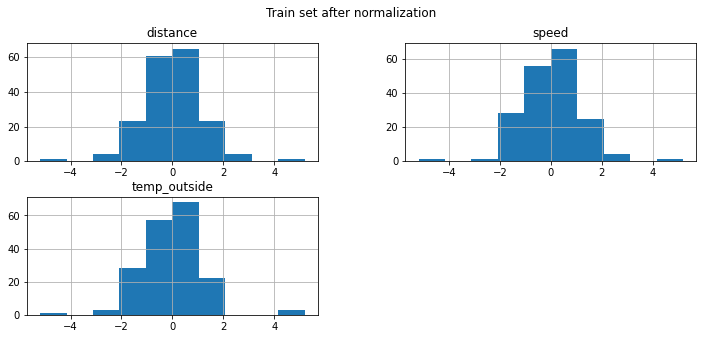

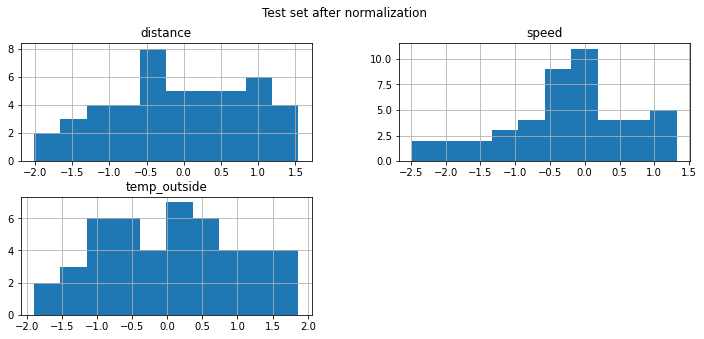

In [4]:
X_train98, X_test98, y_train98, y_test98 = normalizer(sp98, ['distance', 'speed', 'temp_outside'], train_test=True)

### RandomizedSearchCV

Una vez normalizados y escalados los datos, construimos el grid con los distintos valores que queremos que esta tome para los hiperparámetros más importantes:

In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(100, 1000, 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 30)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10, 12]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Con este grid, el algoritmo tendrá a su disposición 30 x 3 x 31 x 6 x 7 x 2 = 234360 combinaciones diferentes para seleccionar aleatoriamente.

¿Cuantas de esas combinaciones será probadas? Todo va a depender de los números que demos a los parámetros 'n_iter' y 'cv' en la función RandomizedSearchCV. En mi caso utilizaré 150 iteraciones con un cv de 6.

In [18]:
rf = RandomForestRegressor()

rf_random_98 = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 150,
                               scoring = 'neg_root_mean_squared_error',
                               cv = 6, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

Con el modelo creado, podemos pasar a entrenarlo con X e y train.

In [19]:
rf_random_98.fit(X_train98, y_train98)

Fitting 6 folds for each of 150 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  4.2min finished


RandomizedSearchCV(cv=6, estimator=RandomForestRegressor(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 13, 16, 20, 23, 27,
                                                      30, 34, 37, 41, 44, 47,
                                                      51, 54, 58, 61, 65, 68,
                                                      72, 75, 78, 82, 85, 89,
                                                      92, 96, 99, 103, 106, 110, ...],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10,
                                                             12],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25],

Con el modelo entrenado podemos ver los mejores parámetros escogidos, además de hacer una predicción y ver el error que esta arroja.

In [25]:
rf_random_98.best_params_

{'n_estimators': 565,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 58,
 'bootstrap': True}

In [27]:
y_pred98 = rf_random_98.predict(X_test98)

from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test98, y_pred98))

0.6094549752326692

Comparando con el error arrojado en la prueba general, en este caso el RMSE se ha reducido en 0.05 más o menos, lo cual no es una gran mejora, pero si confirma que el camino escogido es bueno.

En la siguiente fase podremos centrarnos en mejorar esos mejores parámetros arrojados mediante la función de sklearn 'GridSearchCV'.

### GridSearchCV

Como en el paso anterior, lo primero será construir otro grid, en este caso afinando los rangos de algunos parámetros como: 
 - n_estimators: el mejor parámetro fue 565. En este caso probaré con una lista con 400, 500, 600 y 1000
 - min_samples_split: el mejor parámetro fue 10. En este caso probaré con 4 números por arriba y 4 por abajo de 10.
 - min_samples_leaf: el mejor parámetro fue 1, así que lo mantendré así (por defecto es 1).
 - max_features: mantendré el mejor parámetro 'auto'.
 - max_depth: el mejor parámetro fue 58, así que probaré con 30, 40, 50, 60, y 70.
 - bootstrap: mantendré el 'True' que viene por defecto.
 
Tras este paso podremos crear el modelo de base, el algoritmo de grid search, entrenarlo y mostrar los mejores parámetros, así como analizar si el RMSE mejora.

In [28]:
param_grid = {
    'max_depth': [30, 40, 50, 60, 70],
    'min_samples_split': [6,7,8,9,10,11,12,13,14],
    'n_estimators': [400, 500, 550, 560, 600, 1000]
}

rf = RandomForestRegressor()

rf_grid98 = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 6, n_jobs = -1, verbose = 2)

rf_grid98.fit(X_train98, y_train98)

Fitting 6 folds for each of 270 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 10.6min finished


GridSearchCV(cv=6, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [30, 40, 50, 60, 70],
                         'min_samples_split': [6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'n_estimators': [400, 500, 550, 560, 600, 1000]},
             verbose=2)

In [29]:
rf_grid98.best_params_

{'max_depth': 50, 'min_samples_split': 14, 'n_estimators': 400}

In [30]:
y_pred98_grid = rf_grid98.predict(X_test98)

np.sqrt(mean_squared_error(y_test98, y_pred98_grid))

0.6092306604230942

El RMSE ha descendido de forma muy leve, vamos a ver qué parámetros lo han hecho posible:
 - max_depth: en este caso el mejor parámetro ha sido 50. Anteriormente fue 58, por lo que podemos pensar que el mejor parámetro para este caso está entre 50 y 60.
 - min_samples_split: en este caso han sido 14, en el anterior 10. Puede que el mejor parámetro esté entre 14 y 20.
 - n_estimators: en el anterior caso estuvo en 565, en este caso en 400, aunque el modelo tenía números más cercanos a 565 donde elegir, y, en este caso, ha podido probarlos. Podemos inferir entonces que el número óptimo para este parámetro estará más cercano a los 400.
 
Con esta información, voy a realizar un último intento, utilizando valores más precisos.

In [35]:
param_grid = {
    'max_depth': np.arange(50,61,1),
    'min_samples_split': np.arange(14,21,1),
    'n_estimators': np.arange(390,411,4)
}

rf = RandomForestRegressor()

rf_grid98_2 = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 6, n_jobs = -1, verbose = 2)

rf_grid98_2.fit(X_train98, y_train98)

Fitting 6 folds for each of 462 candidates, totalling 2772 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 2772 out of 2772 | elapsed: 10.5min finished


GridSearchCV(cv=6, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
                         'min_samples_split': array([14, 15, 16, 17, 18, 19, 20]),
                         'n_estimators': array([390, 394, 398, 402, 406, 410])},
             verbose=2)

In [36]:
rf_grid98_2.best_params_

{'max_depth': 51, 'min_samples_split': 19, 'n_estimators': 394}

In [37]:
y_pred98_2_grid = rf_grid98_2.predict(X_test98)

np.sqrt(mean_squared_error(y_test98, y_pred98_2_grid))

0.6231206934062399

### Conclusión y elección del modelo

Como se puede apreciar, este último afinado de hiperparámetros ha empeorado el RMSE, por lo tanto nos quedaremos con el modelo resultante del primer Grid Search, que es el que ha arrojado un menor RMSE. Dicho modelo quedará guardado para su posterior utilización.

In [72]:
import pickle

filename = 'models/sp98_rfr_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rf_grid98, file)

### Gasolina SP95

Mismo procedimiento para el caso de la gasolina SP95: separamos el dataset en train y test, normalizando y escalando ambas divisiones.

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (160). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


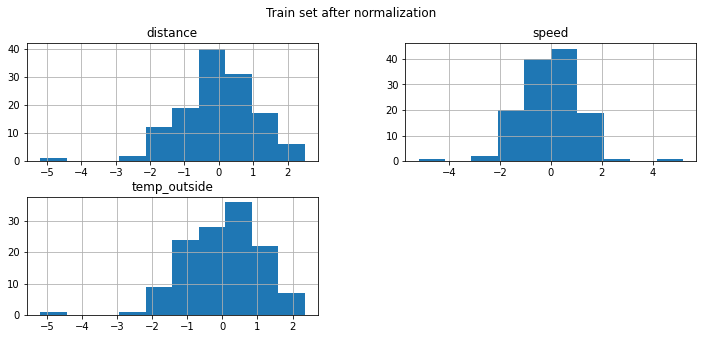

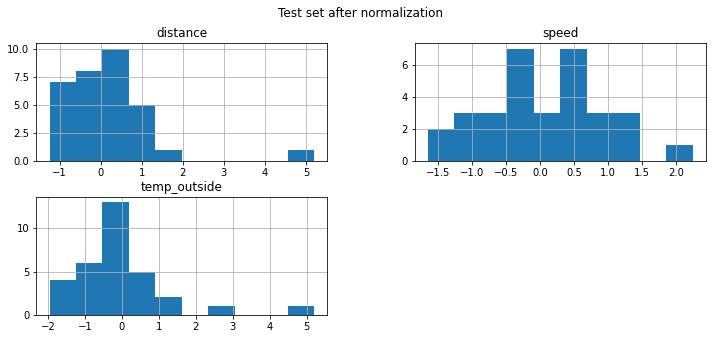

In [73]:
X_train95, X_test95, y_train95, y_test95 = normalizer(sp95, ['distance', 'speed', 'temp_outside'], train_test=True)

### Randomized Search

Para este caso utilizaré el mismo grid search que para la gasolina SP98

In [74]:
rf = RandomForestRegressor()

rf_random_95 = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 150,
                               scoring = 'neg_root_mean_squared_error',
                               cv = 6, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

rf_random_95.fit(X_train95, y_train95)

Fitting 6 folds for each of 150 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  4.2min finished


RandomizedSearchCV(cv=6, estimator=RandomForestRegressor(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 13, 16, 20, 23, 27,
                                                      30, 34, 37, 41, 44, 47,
                                                      51, 54, 58, 61, 65, 68,
                                                      72, 75, 78, 82, 85, 89,
                                                      92, 96, 99, 103, 106, 110, ...],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10,
                                                             12],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25],

In [75]:
rf_random_95.best_params_

{'n_estimators': 751,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 37,
 'bootstrap': True}

In [76]:
y_pred95 = rf_random_95.predict(X_test95)

np.sqrt(mean_squared_error(y_test95, y_pred95))

0.41356156764389795

En este caso el error sufre una mejora notable con respecto a la prueba general, lo cual es una muy buena noticia.

Veremos si es posible mejorarlo aún más con el Grid Search

### GridSearchCV

Como ya hemos hecho, primero afinamos los rangos del grid:

 - n_estimators: el mejor parámetro fue 751. En este caso probaré con una lista con 600, 700, 800 y 1000
 - min_samples_split: el mejor parámetro fue 5. En este caso probaré con 4 números por arriba y uno por debajo.
 - min_samples_leaf: el mejor parámetro fue 1, así que lo mantendré así (por defecto es 1).
 - max_features: en este caso fue 'sqrt', que será el que mantenga.
 - max_depth: el mejor parámetro fue 37, así que probaré con 20, 30, 40, 50, y 60.
 - bootstrap: mantendré el 'True' que viene por defecto.

Tras este paso podremos crear el modelo de base, el algoritmo de grid search, entrenarlo y mostrar los mejores parámetros, así como analizar si el RMSE mejora.

In [77]:
param_grid = {
    'max_depth': [20, 30, 40, 50, 60],
    'min_samples_split': [4,5,6,7,8,9],
    'n_estimators': [600, 700, 750, 760, 800, 1000],
    'max_features': ['sqrt']
}

rf = RandomForestRegressor()

rf_grid95 = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 6, n_jobs = -1, verbose = 2)

rf_grid95.fit(X_train95, y_train95)

Fitting 6 folds for each of 180 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  8.2min finished


GridSearchCV(cv=6, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40, 50, 60],
                         'max_features': ['sqrt'],
                         'min_samples_split': [4, 5, 6, 7, 8, 9],
                         'n_estimators': [600, 700, 750, 760, 800, 1000]},
             verbose=2)

In [78]:
rf_grid95.best_params_

{'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 750}

In [79]:
y_pred95_gs = rf_grid95.predict(X_test95)

np.sqrt(mean_squared_error(y_test95, y_pred95_gs))

0.4214759596307983

### Conclusión y elección del modelo

Como se puede apreciar, este último afinado de hiperparámetros ha empeorado el RMSE, por lo tanto nos quedaremos con el modelo resultante del Randomized Search, que es el que ha arrojado un menor RMSE. Dicho modelo quedará guardado para su posterior utilización.

In [90]:
filename = 'models/sp95_rfr_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(rf_random_95, file)